### Best parameters and resultso far:
**Parameter Grid (Catboost) :**
```python
params_dict = {
    'learning_rate': [0.6, 0.1, 0.8],
    'iterations': [10, 10, 50],
    'depth': [6, 1, 8],
    'min_data_in_leaf': [0],
    'subsample': [0.6, 0.1, 0.8],
    'colsample_bylevel': [1.0],
    'l2_leaf_reg': [8, 1, 10],
}
Best parameters: {'learning_rate': 0.8, 'iterations': 10, 'depth': 6, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}
Best f1score score on train: 77.05%
Best f1score score on test: 76.04%
```

### Import Titanic dataset

In [3]:
import joblib

data = joblib.load( 'preprocessed_data\\Titanic.pkl')

## Create train test, in this case create separations too, like continuous and encoded columns

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["X_encoded_scaled"], data["y"], test_size=0.33/2, random_state=42)
X_train_continuous = X_train[['Age', 'SibSp', 'Parch', 'Fare']]
X_train_encoded = X_train[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
X_test_continuous = X_test[['Age', 'SibSp', 'Parch', 'Fare']]
X_test_encoded = X_test[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']]
print(X_train.head(5))
print(X_train_continuous.head(5))
print(X_train_encoded.head(5))

          Age  SibSp     Parch      Fare  Sex_female  Sex_male  Embarked_C  \
451  0.744970    0.4  0.000000  0.308418         1.0       0.0         0.0   
377  0.305752    0.0  0.000000  0.058938         1.0       0.0         0.0   
164  0.362426    0.0  0.000000  0.112558         0.0       1.0         1.0   
547  0.050723    0.0  0.166667  0.080381         1.0       0.0         1.0   
610  0.716634    0.2  0.000000  0.467057         1.0       0.0         0.0   

     Embarked_Q  Embarked_S  Pclass_1  Pclass_2  Pclass_3  
451         0.0         1.0       1.0       0.0       0.0  
377         0.0         1.0       0.0       0.0       1.0  
164         0.0         0.0       0.0       0.0       1.0  
547         0.0         0.0       0.0       0.0       1.0  
610         0.0         1.0       1.0       0.0       0.0  
          Age  SibSp     Parch      Fare
451  0.744970    0.4  0.000000  0.308418
377  0.305752    0.0  0.000000  0.058938
164  0.362426    0.0  0.000000  0.112558
547  0.

## Optimisation and visualisation process

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import warnings

def Show_res(results_train, results_test):
    models_and_components = list(results_train.keys())
    train_scores = list(results_train.values())
    test_scores = [results_test[model] for model in models_and_components]

    # Extract model names and component values
    x_labels = models_and_components
    x_ticks = range(len(x_labels))

    # Plot settings
    bar_width = 0.4
    colors = plt.cm.tab10.colors  # Use a colormap for consistent colors

    # Create the bar plot
    plt.figure(figsize=(14, 8))
    for i, (train_score, test_score) in enumerate(zip(train_scores, test_scores)):
        color = colors[i % len(colors)]
        plt.bar(x_ticks[i] - bar_width / 2, train_score, bar_width, color=color, label=f"{x_labels[i]} (train)" if i == 0 else "")
        plt.bar(x_ticks[i] + bar_width / 2, test_score, bar_width, color=color, alpha=0.6, label=f"{x_labels[i]} (test)" if i == 0 else "")

    # Customize plot
    plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45, ha="right")
    plt.ylabel("Score (%)")
    plt.title("Model Performance on Train and Test Data")
    plt.legend(loc="best")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

def optimize(X_train_op, X_test_op, y_train_op, y_test_op, X_train_add=None, X_test_add=None):

    # dont show warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

    # Initialize StratifiedKFold
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Initialize results
    results_train = {}
    results_test = {}


    for c in range(2,20):
        # Clustering and evaluation
        clustering_models = {
            "KMeans": KMeans(n_clusters=c, random_state=0, verbose=0),
            "GaussianMixture": GaussianMixture(n_components=c, random_state=0),
        }

        for name, model in clustering_models.items():
            
            cluster_labels = model.fit_predict(X_train)

            # Add cluster labels as a feature
            X_train_clustering = np.hstack([X_train_op, cluster_labels.reshape(-1, 1)])
            X_test_clustering = np.hstack([X_test_op, model.predict(X_test).reshape(-1, 1)])

            # Convert numpy arrays to DataFrames for compatibility with pd.concat
            X_train_clustering = pd.DataFrame(X_train_clustering)
            X_test_clustering = pd.DataFrame(X_test_clustering)

            # Add additional features if provided
            if X_train_add is not None:
                X_train_clustering = pd.concat([X_train_clustering, X_train_add.reset_index(drop=True)], axis=1)
                X_test_clustering = pd.concat([X_test_clustering, X_test_add.reset_index(drop=True)], axis=1)

            # Train and evaluate
            CatB = CatBoostClassifier(
                learning_rate=0.8, iterations=10, depth=6, min_data_in_leaf=1,
                subsample=0.8, colsample_bylevel=1.0, l2_leaf_reg=10, 
                random_state=0, verbose=0
            )

            scores = cross_val_score(CatB, X_train_clustering, y_train_op, cv=kf, scoring='f1')
            results_train[name + " clstrs" + str(c)] = scores.mean() * 100

            CatB.fit(X_train_clustering, y_train)
            y_pred_test = CatB.predict(X_test_clustering)
            results_test[name + " clstrs" + str(c)] = f1_score(y_test_op, y_pred_test) * 100

    Show_res(results_train, results_test)




## Run quick optimisation on Random forest to check feature importance

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters:  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Train ACC:  0.8913525498891353
Test ACC:  0.6746987951807228


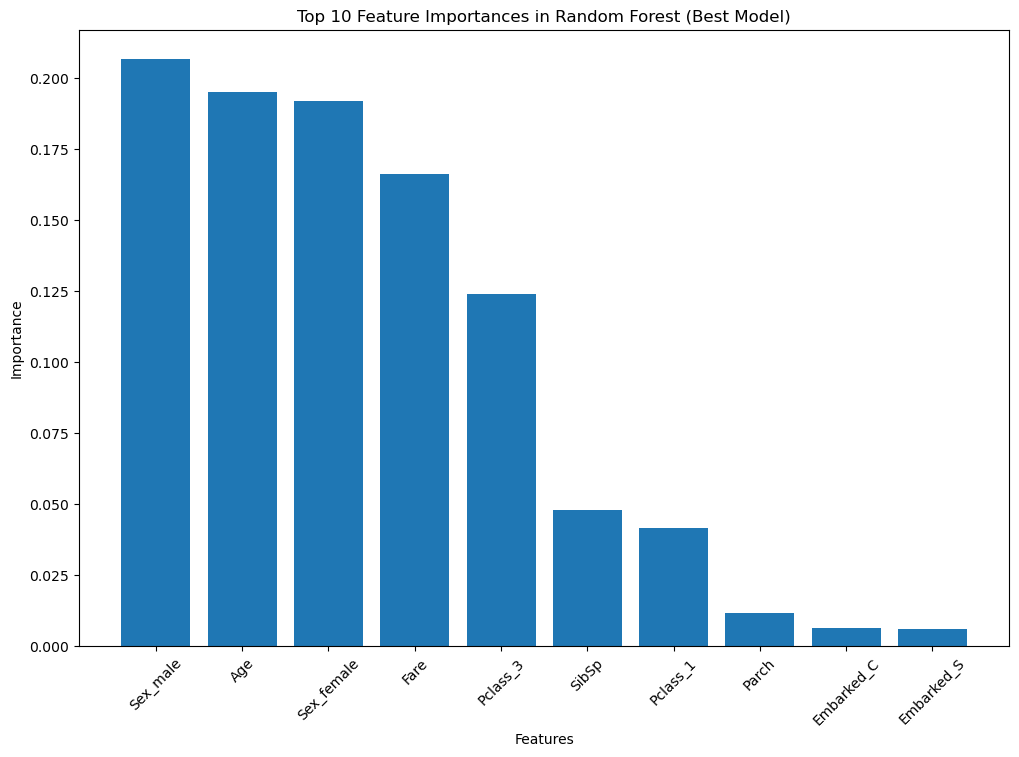

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the Random Forest model
base_model = RandomForestClassifier(random_state=0, n_jobs=-1)

# Parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_model = grid_search.best_estimator_
print("Best Parameters: ", grid_search.best_params_)

# Evaluate on training and test sets
pred_train = best_model.predict(X_train)
pred_test = best_model.predict(X_test)

print("Train ACC: ", f1_score(y_train, pred_train))
print("Test ACC: ", f1_score(y_test, pred_test))

# Feature importance for the best model
feature_importances = best_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else np.arange(X_train.shape[1])

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = np.array(feature_importances)[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Visualize top N features
top_n = 10
top_n_indices = sorted_indices[:top_n]
top_n_feature_importances = sorted_feature_importances[:top_n]
top_n_feature_names = sorted_feature_names[:top_n]

plt.figure(figsize=(12, 8))
plt.title("Top 10 Feature Importances in Random Forest (Best Model)")
plt.bar(top_n_feature_names, top_n_feature_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


### For reference first do clustering on all features

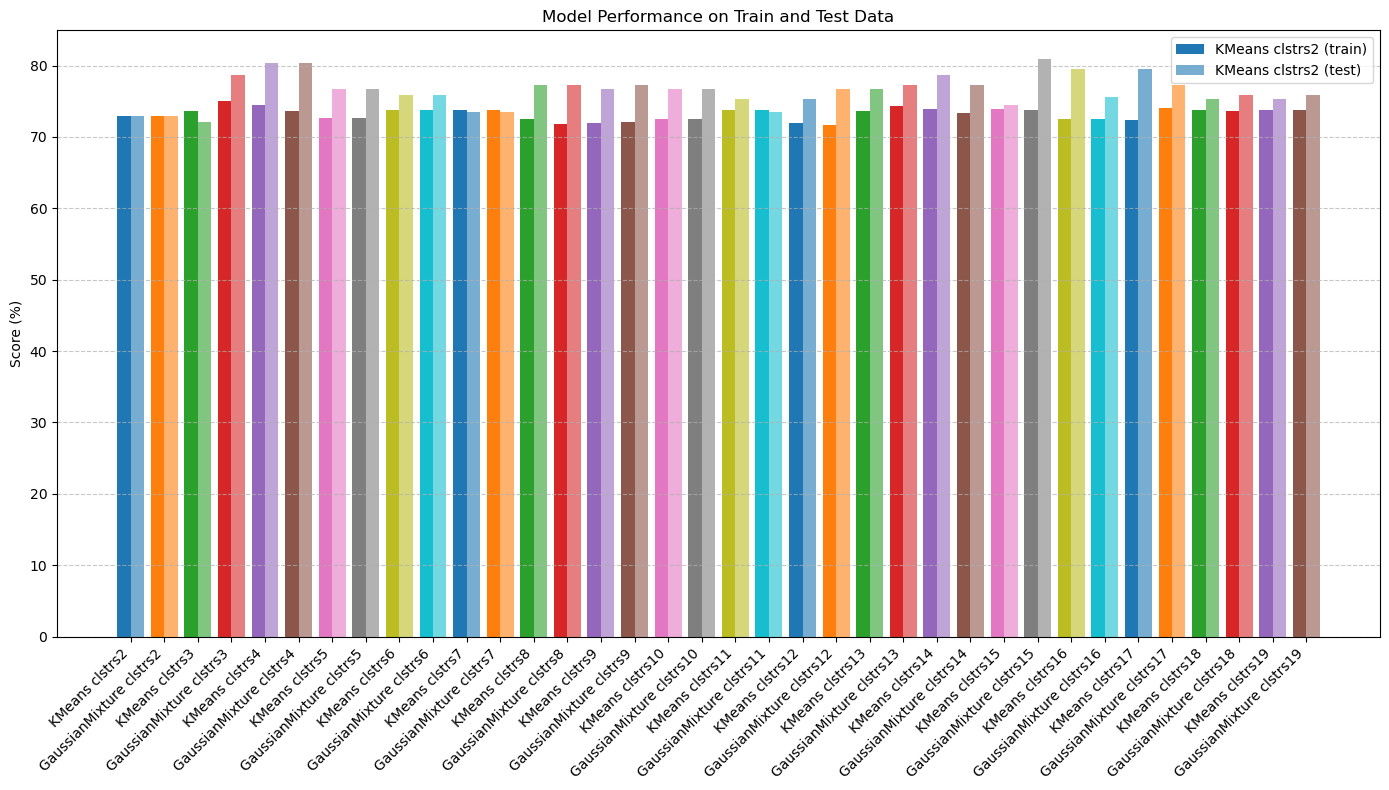

In [7]:
optimize(X_train, X_test, y_train, y_test)

### Not a significant better result, tests are sometimes better but trains nearly the same

# cluster without categorical data

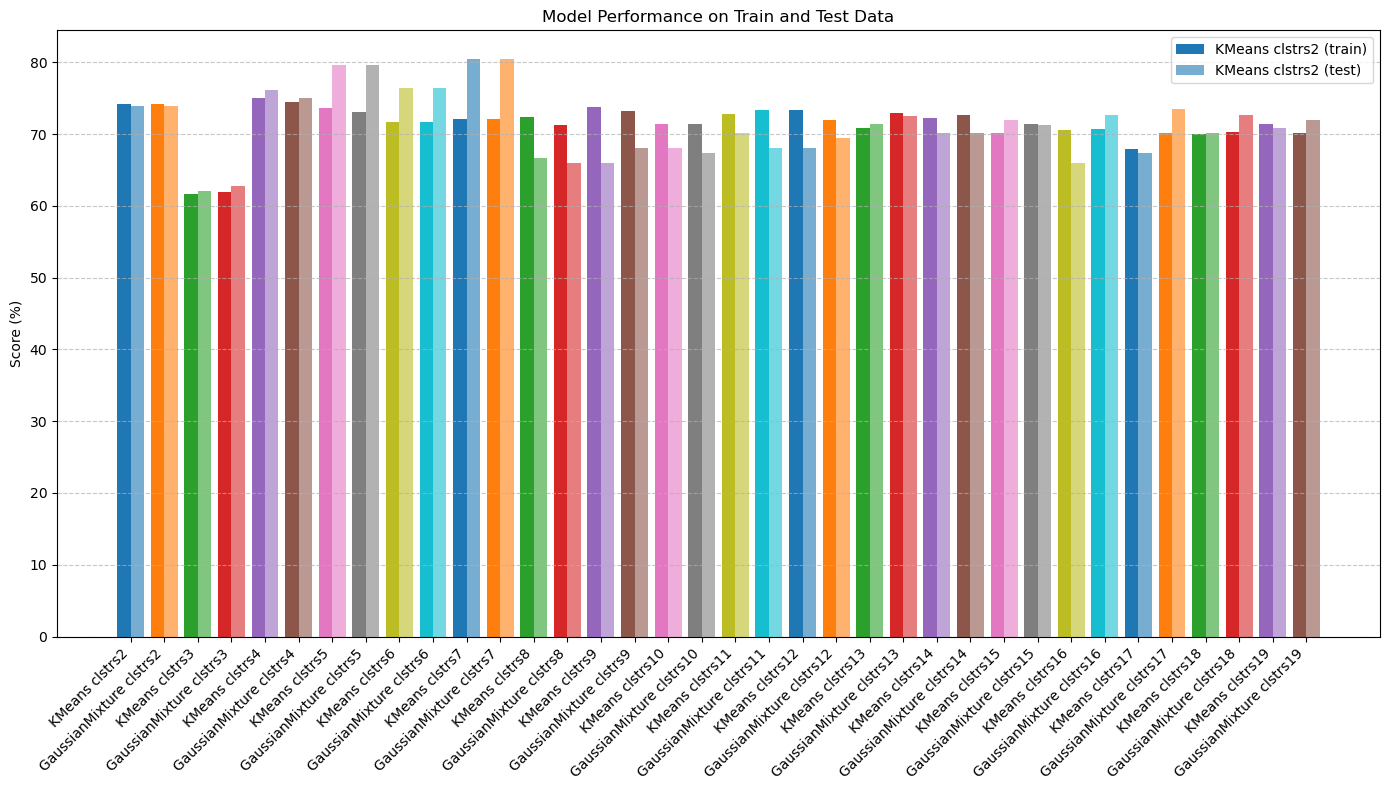

In [8]:
optimize(X_train_continuous, X_test_continuous, y_train, y_test)

### More mixed result, we lost the information of the categorical data

# cluster without categorical data, but add it after clustering

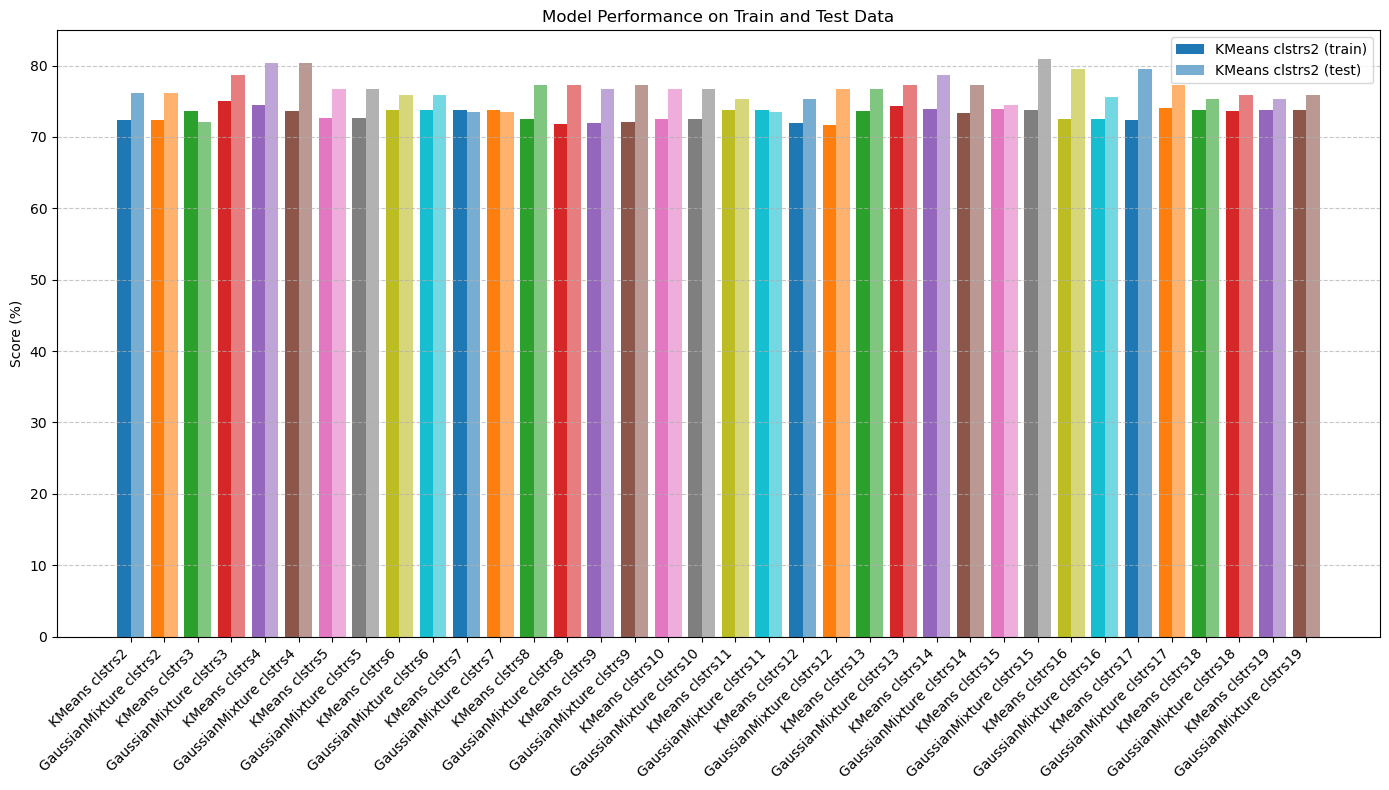

In [9]:
optimize(X_train_continuous, X_test_continuous, y_train, y_test, X_train_encoded, X_test_encoded)

### Nearly the same result like with the whole dataset, maybe the gaussianMixture with 3 clusters

## Separate data by feature importance

In [10]:
# Columns to include in the first DataFrame
columns_group = ['Sex_male', 'Age', 'Sex_female', 'Fare', 'Pclass_3']

# Creating the first group with specified columns
X_train_best = X_train[columns_group]
X_test_best = X_test[columns_group]

# Creating the second group with the remaining columns
X_train_rest = X_train.drop(columns=columns_group)
X_test_rest = X_test.drop(columns=columns_group)

## Clusterise only the columns with the highest importance and create a model ftom it

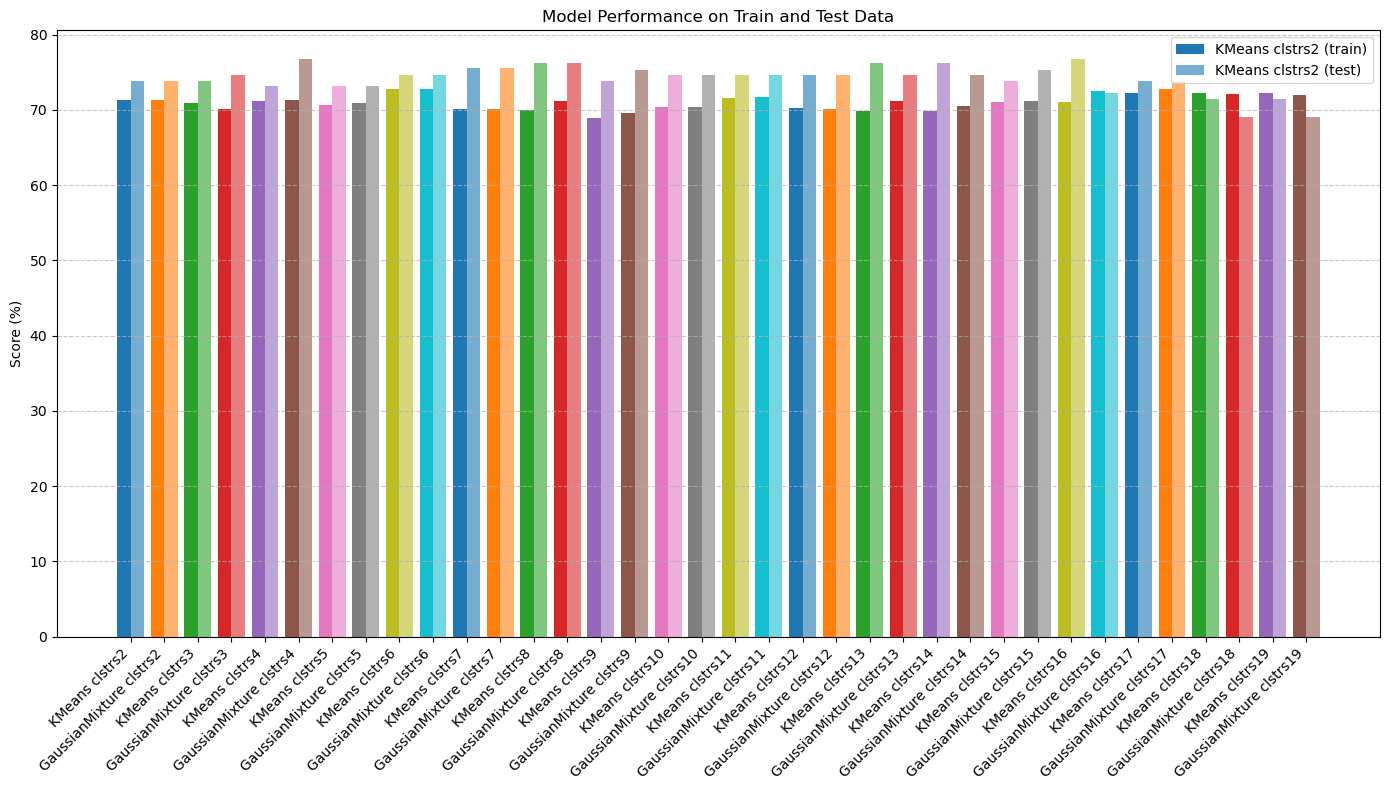

In [11]:

optimize(X_train_best, X_test_best, y_train, y_test)


## Same process like previous, but add 'rest' coluns befor model creating

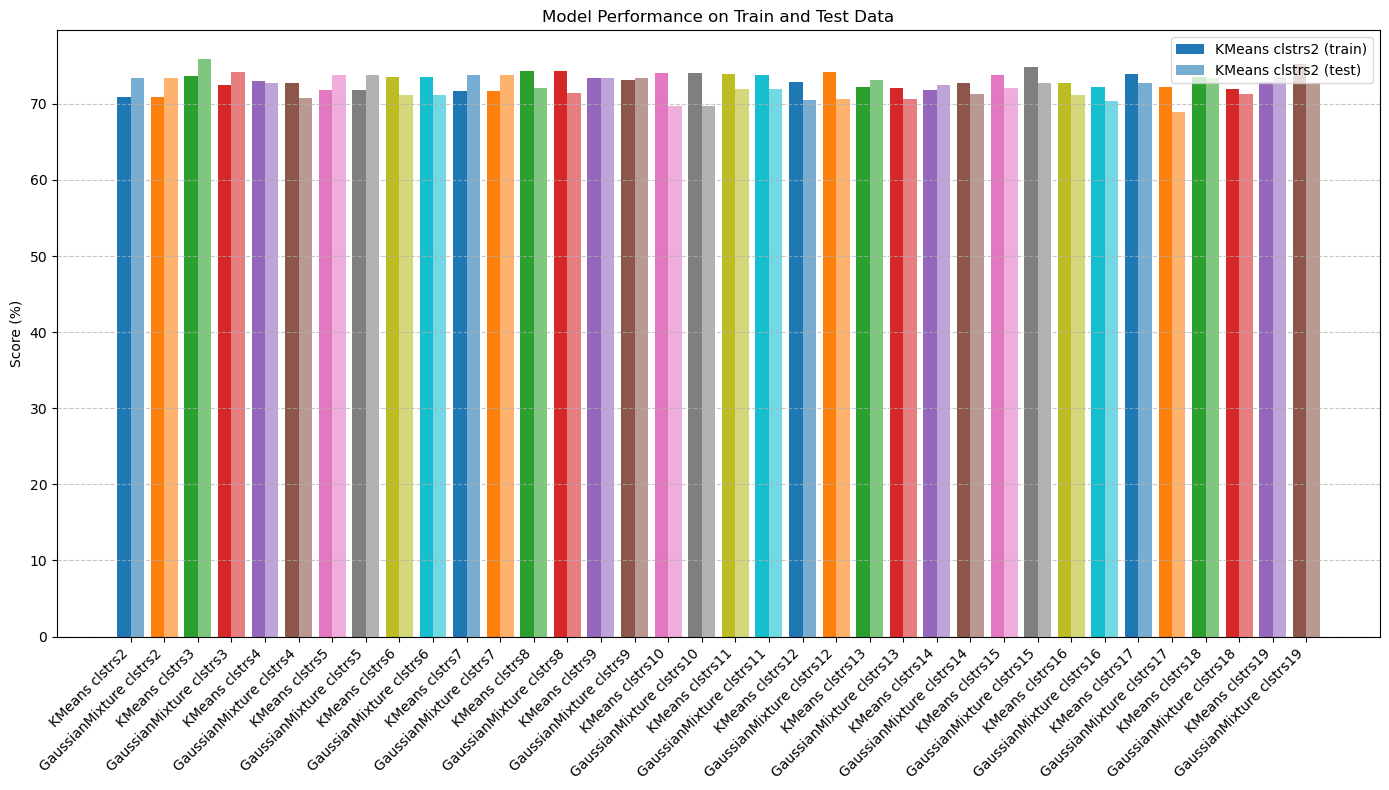

In [12]:
optimize(X_train_best, X_test_best, y_train, y_test, X_train_rest, X_test_rest)

## Check result of GaussianMixture with 3 clusters

In [14]:

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

model = GaussianMixture(n_components=3, random_state=0)
cluster_labels = model.fit_predict(X_train)

# Add cluster labels as a feature
X_train_clustering = np.hstack([X_train_continuous, cluster_labels.reshape(-1, 1)])
X_test_clustering = np.hstack([X_test_continuous, model.predict(X_test).reshape(-1, 1)])

# Convert numpy arrays to DataFrames for compatibility with pd.concat
X_train_clustering = pd.DataFrame(X_train_clustering)
X_test_clustering = pd.DataFrame(X_test_clustering)

# Add additional features
X_train_clustering = pd.concat([X_train_clustering, X_train_encoded.reset_index(drop=True)], axis=1)
X_test_clustering = pd.concat([X_test_clustering, X_test_encoded.reset_index(drop=True)], axis=1)

# Train and evaluate
CatB = CatBoostClassifier(
    learning_rate=0.8, iterations=10, depth=6, min_data_in_leaf=1,
    subsample=0.8, colsample_bylevel=1.0, l2_leaf_reg=10, 
    random_state=0, verbose=0
)

scores = cross_val_score(CatB, X_train_clustering, y_train, cv=kf, scoring='f1')
print("CrossValScore: ",scores.mean() * 100)

CatB.fit(X_train_clustering, y_train)
y_pred_test = CatB.predict(X_test_clustering)
print("TestResult: ", f1_score(y_test, y_pred_test) * 100)

CrossValScore:  74.97437731167491
TestResult:  78.65168539325843


## In conclusion, clustering using these methods did not yield better results